# The Kalman Filter (KF)

The KF is one of the most widely used algorithms in time-series applications, such as tracking objects or state estimation in robot navigation. In this notebook, we'll provide a brief overview of the main theory underlying the KF and then demonstrate its utility in an application where we track an object moving in $\mathbb{R}^3$ space, given noisy measurements of its location.

Below are the necessary imports for this notebook:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

# GPU suitable form of NumPy, also works on the CPU
from jax import numpy as jnp
from jax import random as jr
from jax import vmap

# JAX library for SSMs
from dynamax.utils.plotting import plot_uncertainty_ellipses
from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.linear_gaussian_ssm import lgssm_smoother, lgssm_filter

jnp.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness"
key = jr.PRNGKey(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

<b>Aside:</b> please note the inclusion of [JAX](https://github.com/google/jax) and [Dynamax](https://github.com/probml/dynamax). JAX is akin to NumPy in syntax and use, but processes instructions on the GPU, efficiently computes gradients (autograd), and reaps the benefits of [just-in-time (JIT) compilation](https://en.wikipedia.org/wiki/Just-in-time_compilation) (e.g., [Numba](https://numba.pydata.org/)), which are all advantageous features for machine learning coding. 

Dynamax is a library written in JAX for state space models (SSMs). The KF is an algorithm that applies to a special type of SSM: a Linear-Gaussian SSM (LG-SSM). 

You should follow the [installation instructions](https://github.com/google/jax#installation) for JAX (feel free to use CPU/GPU in this notebook). You can also refer [here](https://github.com/cloudhan/jax-windows-builder) if you're a Windows user.

## Posterior Inference in SSMs

Consider the problem of tracking the internal state vector of a dynamical system in the presence of noise and other inaccuracies using:
- Knowledge of the system equations; and
- Measured outputs or observations in time.

A popular model of sequential data suitable for this type of problem is a <b>state space model (SSM)</b>. To capture the "internal state" (or hidden state) of a system, we often think of latent variable models, e.g., [hidden Markov models (HMMs)](https://en.wikipedia.org/wiki/Hidden_Markov_model), and a means of deriving these latent variables from observable data, such as [PCA](../unsupervised_learning/pca_dim_reduction.ipynb). For a dynamical system in particular, it is appropriate to adopt latent variable <i>sequence</i> models, where HMMs and SSMs are typical examples of this class of chain-structured graphical models. We thus opt to utilize an SSM for our tracking problem.

More specifically, an SSM is a <b>partially observed Markov model</b>, where the hidden state evolves over time according to a Markov process (assumption that future states of the process depend only upon the present state), and these hidden states generate observations at each timestep. An SSM can be represented as a stochastic discrete-time dynamical system of the form:

\begin{align*}
\mathbf{z}_t &= \mathbf{f}(\mathbf{z}_{t-1}, \mathbf{u}_t, \mathbf{q}_t) \\
\mathbf{x}_t &= \mathbf{h}(\mathbf{z}_{t}, \mathbf{u}_t, \mathbf{r}_t) 
\end{align*}

where $\mathbf{z}_t \in \mathbb{R}^{N_z}$ is the true or hidden state at time $t$, $\mathbf{x}_t \in \mathbb{R}^{N_x}$ is the observation (output), and $\mathbf{u}_t \in \mathbb{R}^{N_u}$ is an optional control input. The function $\mathbf{f}$ is the state <b>transition</b> or <b>dynamics function</b>, and $\mathbf{h}$ is the <b>observation function</b>, both of which are possibly non-linear functions. Lastly, $\mathbf{q}_t$ is the <b>process noise</b> and $\mathbf{r}_t$ is the <b>observation noise</b>.

In an SSM, two common time-series tasks are 1) to infer the hidden states of the model given incoming observations; and 2) use the model to predict future observations. Our main objective here is the former task, where we wish to find the true internal state of the dynamical system given a sequence of observations. Rather than expressing the SSM as a deterministic function of random noise, we can also rewrite its equations in a probabilistic form:

\begin{align*}
p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1}, \mathbf{u}_t) &= p(\mathbf{z}_t \, | \, \mathbf{f}(\mathbf{z}_{t-1}, \mathbf{u}_t))  \\
p(\mathbf{x}_t \, | \, \mathbf{z}_t, \mathbf{u}_t) &= p(\mathbf{x}_t \, | \, \mathbf{h}(\mathbf{z}_{t}, \mathbf{u}_t))
\end{align*}

where $p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1}, \mathbf{u}_t)$ is the <b>transition model</b> and $p(\mathbf{x}_t \, | \, \mathbf{z}_t, \mathbf{u}_t)$ is the <b>observation model</b>. 

Unrolling over time, we can write the corresponding joint distribution of the SSM as:

\begin{equation*}
p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T} \, | \, \mathbf{u}_{1:T}) = \left[ p(\mathbf{z}_1 \, | \, \mathbf{u}_1) \prod_{t=2}^T p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1}, \mathbf{u}_t) \right] \left[ \prod_{t=1}^T p(\mathbf{x}_t \, | \, \mathbf{z}_{t}, \mathbf{u}_t) \right],
\end{equation*}

where $p(\mathbf{z}_1 \, | \, \mathbf{u}_1)$ is the prior or initial state distribution, sometimes denoted as $p(\mathbf{z}_0)$. When there are no external inputs, as we will assume for the remainder of this notebook, then the joint distribution further simplifies to:

\begin{equation*}
p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T}) = \left[ p(\mathbf{z}_1) \prod_{t=2}^T p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1}) \right] \left[ \prod_{t=1}^T p(\mathbf{x}_t \, | \, \mathbf{z}_{t}) \right].
\end{equation*}

The SSM joint distribution can be written in the above form due to two assumptions. First, the Markov assumption that the true state depends only on the immediately previous state, i.e., $p(\mathbf{z}_t \, | \, \mathbf{z}_{1}, \ldots,\mathbf{z}_{t-1}) = p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1})$. Second, the assumption that the current measurement, $\mathbf{x}_{t}$, is conditionally independent of all past observations, $\mathbf{x}_{1:t-1}$, given the current hidden state, $\mathbf{z}_{t}$.

Viewing the SSM described above from a Bayesian perspective, our task of finding the true state of the system has now been reframed as performing posterior inference about the hidden states, also known as <b>state estimation</b>. For example, consider an object moving around in 2D space. Our aim is to estimate its location and velocity $\mathbf{z}_t \in \mathbb{R}^4$ given noisy sensor measurements of its location $\mathbf{x}_t \in \mathbb{R}^2$. A <b>linear-Gaussian SSM (LG-SSM)</b> is a suitable model for this task, where we must compute the <b>belief state</b>, $p(\mathbf{z}_t \, | \, \mathbf{x}_{1:t})$, i.e., our posterior of interest. This is known as <b>Bayesian filtering</b>. If the belief state is represented as a Gaussian, then the KF is capable of solving this task, as we will see in the [later tracking application](#Tracking-an-Object-using-a-KF). While filtering is performed <i>online</i>, meaning inference is performed using only the data observed up to $t$, another more accurate state estimation technique for <i>offline</i> use is known as <b>Bayesian smoothing</b>. In this setting, the aim is to compute $p(\mathbf{z}_t \, | \, \mathbf{x}_{1:T})$, where all the data in the sequence up to time $T$ has already been observed. 

Please refer to Chapter 8 of Murphy's "Probabilistic Machine Learning: Advanced Topics" book for more background information on Gaussian filtering and smoothing, as we will only glance at filtering and the KF in this notebook.

## Bayesian Filtering

[Recursive Bayesian estimation](https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation), also known as the <b>Bayes filter</b>, is an algorithm to estimate an unknown probability density function recursively over time using incoming measurements and a known model. In other words, we can use a Bayes filter to recursively compute the belief state, $p(\mathbf{z}_t \, | \, \mathbf{x}_{1:t})$, given the prior belief from the previous step, $p(\mathbf{z}_{t-1} \, | \, \mathbf{x}_{1:t-1})$, the new observation, $\mathbf{x}_{t}$, and our known mathematical process model. Sequential Bayesian updating can be performed at constant time complexity to recursively estimate this belief state. For a dynamical system, the overall procedure boils down to a <b>predict-update</b> cycle.

In the <b>prediction step</b>, we have the <b>Chapman-Kolmogorov equation</b> to compute the one-step-ahead predictive distribution for the hidden state:

\begin{equation*}
p(\mathbf{z}_{t} \, | \, \mathbf{x}_{1:t-1}) = \int p(\mathbf{z}_{t} \, | \, \mathbf{z}_{t-1})p(\mathbf{z}_{t-1} \, | \, \mathbf{x}_{1:t-1})d\mathbf{z}_{t-1}.
\end{equation*}

This equation updates the posterior from the previous timestep, $p(\mathbf{z}_{t-1} \, | \, \mathbf{x}_{1:t-1})$, into the prior for the current step, $p(\mathbf{z}_{t} \, | \, \mathbf{x}_{1:t-1})$.

The <b>update step</b> is then simply Bayes' rule:

\begin{equation*}
p(\mathbf{z}_{t} \, | \, \mathbf{x}_{1:t}) = \frac{1}{Z_t} p(\mathbf{x}_{t} \, | \, \mathbf{z}_{t})p(\mathbf{z}_{t} \, | \, \mathbf{x}_{1:t-1}),
\end{equation*}

where the normalization constant, $Z_t$, is:

\begin{equation*}
Z_t = \int p(\mathbf{x}_{t} \, | \, \mathbf{z}_{t})p(\mathbf{z}_{t} \, | \, \mathbf{x}_{1:t-1})d\mathbf{z}_{t} = p(\mathbf{x}_{t} \, | \, \mathbf{x}_{1:t-1}).
\end{equation*}

The normalization constants can also be utilized to provide the log-likelihood of the sequence:

\begin{equation*}
\log p(\mathbf{x}_{1:T}) = \sum_{t=1}^T \log p(\mathbf{x}_{t} \, | \, \mathbf{x}_{1:t-1}) = \sum_{t=1}^T \log Z_t,
\end{equation*}

where we define $p(\mathbf{x}_{1} \, | \, \mathbf{x}_{0}) = p(\mathbf{x}_{1})$. This quantity is the sum of log probabilities of the one-step-ahead measurement predictions, so it can be regarded as a measure of how "surprised" the model is at each timestep.

Next let's examine the KF, an algorithm for <i>exact</i> Bayesian filtering in a specific type of SSM: linear-Gaussian SSMs (LG-SSMs). 

## KF Formulation

Computing the integrals required to implement Bayesian filtering is generally intractable. However, if the state space is <i>discrete</i>, as in an HMM, or if the SSM is a linear-Gaussian model, then the belief state can be represented by a distribution with a closed-form solution. The KF is an algorithm that specifically operates on the latter case of the LG-SSM, where all the distributions are linear-Gaussian.

For the KF to apply, we will also assume that the SSM used to represent our dynamical system can be described by the following equations:

\begin{align*}
\mathbf{z}_t &= \mathbf{f}(\mathbf{z}_{t-1}, \mathbf{u}_t) + \mathbf{q}_t \\
\mathbf{x}_t &= \mathbf{h}(\mathbf{z}_{t}, \mathbf{u}_t) + \mathbf{r}_t 
\end{align*}

where $\mathbf{f}$ is a known <b>linear</b> transition function, $\mathbf{h}$ is a known <b>linear</b> observation function, $\mathbf{q}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_t)$ is additive process noise assumed to be drawn from a zero-mean multivariate Gaussian with known covariance $\mathbf{Q}_t$, and similarly $\mathbf{r}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_t)$ is observation noise with a known covariance matrix $\mathbf{R}_t$. For simplicity in this example, we will also assume no external inputs $\mathbf{u}_t$ going forward.

The above LG-SSM, also known as a <b>linear dynamical system (LDS)</b>, is written in its deterministic form as:

\begin{align*}
\mathbf{z}_t &= \mathbf{F}_t\mathbf{z}_{t-1} + \mathbf{q}_t \\
\mathbf{x}_t &= \mathbf{H}_t\mathbf{z}_{t} + \mathbf{r}_t 
\end{align*}

where $\mathbf{F}_t$ and $\mathbf{H}_t$ are known state transition and observation matrices, respectively.

Or alternatively, the LG-SSM can be written in its probabilistic form with all the probability densities represented as Gaussian:

\begin{align*}
p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1}) &= \mathcal{N}(\mathbf{z}_t \, | \, \mathbf{F}_t\mathbf{z}_{t-1}, \mathbf{Q}_t)  \\
p(\mathbf{x}_t \, | \, \mathbf{z}_t) &= \mathcal{N}(\mathbf{x}_t \, | \, \mathbf{H}_t\mathbf{z}_{t}, \mathbf{R}_t)
\end{align*}

The subsequent sections describe the predict-update cycle for the KF under this model, where the belief state at time $t$ is now given as $p(\mathbf{z}_t \, | \, \mathbf{x}_{1:t}) = \mathcal{N}(\mathbf{z}_t \, | \, \boldsymbol{\mu}_{t|t}, \boldsymbol{\Sigma}_{t|t})$, with $\boldsymbol{\mu}_{t|t}$ and $\boldsymbol{\Sigma}_{t|t}$ denoting the posterior mean and covariance given observations $\mathbf{x}_{1:t}$. You may also find $\boldsymbol{\mu}_{t|t}$ written as $\boldsymbol{m}_{t|t}$ and $\boldsymbol{\Sigma}_{t|t}$ written as $\boldsymbol{P}_{t|t}$ in other sources. Please note that the following steps will contain no derivation of their equations (see Chapter 8 of Murphy's advanced topics book for the KF derivation).

### Predict Step

The one-step-ahead prediction step of the hidden state, or the <b>time update step</b>, is equated as follows:

\begin{align*}
p(\mathbf{z}_t \, | \, \mathbf{x}_{1:t-1}) & = \mathcal{N}(\mathbf{z}_t \, | \, \boldsymbol{\mu}_{t|t-1}, \boldsymbol{\Sigma}_{t|t-1}) \\
\boldsymbol{\mu}_{t|t-1} &= \mathbf{F}_t\boldsymbol{\mu}_{t-1|t-1} \\
\boldsymbol{\Sigma}_{t|t-1} &= \mathbf{F}_t\boldsymbol{\Sigma}_{t-1|t-1}\mathbf{F}_t^\intercal + \mathbf{Q}_t
\end{align*}

where $\boldsymbol{\mu}_{t|t-1}$ and $\boldsymbol{\Sigma}_{t|t-1}$ are the predicted <i>a priori</i> state mean and covariance estimates.

### Update Step

The update step, or the <b>measurement step</b>, is then computed using Bayes' rule:

\begin{align*}
p(\mathbf{z}_t \, | \, \mathbf{x}_{1:t}) & = \mathcal{N}(\mathbf{z}_t \, | \, \boldsymbol{\mu}_{t|t}, \boldsymbol{\Sigma}_{t|t}) \\
\mathbf{S}_{t} &= \mathbf{H}_t\boldsymbol{\Sigma}_{t|t-1}\mathbf{H}_t^\intercal + \mathbf{R}_t \\
\mathbf{K}_{t} &= \boldsymbol{\Sigma}_{t|t-1}\mathbf{H}_t^\intercal\mathbf{S}_t^{-1} \\
\boldsymbol{\mu}_{t|t} &= \boldsymbol{\mu}_{t|t-1} + \mathbf{K}_t(\mathbf{x}_t - \mathbf{H}_t\boldsymbol{\mu}_{t|t-1})  \\
\boldsymbol{\Sigma}_{t|t} &= \boldsymbol{\Sigma}_{t|t-1} - \mathbf{K}_{t}\mathbf{H}_{t}\boldsymbol{\Sigma}_{t|t-1}
\end{align*}

where $\mathbf{K}_{t}$ is the <b>Kalman gain matrix</b>, while $\boldsymbol{\mu}_{t|t}$ and $\boldsymbol{\Sigma}_{t|t}$ are the updated <i>a posteriori</i> state mean and covariance estimates. The difference term $\mathbf{e}_t = \mathbf{x}_t - \mathbf{H}_t\boldsymbol{\mu}_{t|t-1}$ is also referred to as the <b>residual error</b> or the <b>innovation</b>.

## Tracking an Object using a KF

Consider an object moving in $\mathbb{R}^3$ space. We want to track this object's motion based on noisy measurements of its location at each timestep. In the code below, we should how to accomplish this task using an LG-SSM and the KF algorithm.

Let the hidden state $\mathbf{z}_t$ encode the location, $(z_{1,t}, z_{2,t}, z_{3,t})$, and the velocity, $(\dot{z}_{1,t}, \dot{z}_{2,t}, \dot{z}_{3,t})$, of the moving object. The measurement variable $\mathbf{x}_t$ is then a noisy observation of this object's location, with velocity not observed but instead inferred from the change in location. Assume that the measurement process is in continuous time, but that we discretize it with a sampling period of $\Delta$. The new location of the object thus follows the dynamics of the following LDS:

\begin{align*}
\underbrace{\begin{pmatrix} z_{1,t} \\ z_{2,t} \\  z_{3,t} \\ \dot{z}_{1,t} \\ \dot{z}_{2,t} \\ \dot{z}_{3,t} \end{pmatrix}}_{\mathbf{z}_t} &= 
    \underbrace{\begin{pmatrix}
    1 & 0 & 0 & \Delta & 0 & 0 \\
    0 & 1 & 0 & 0 & \Delta & 0 \\
    0 & 0 & 1 & 0 & 0 & \Delta \\
    0 & 0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 
    \end{pmatrix}
    }_{\mathbf{F}} \, \underbrace{\begin{pmatrix} z_{1,t-1} \\ z_{2,t-1} \\  z_{3,t-1} \\ \dot{z}_{1,t-1} \\ \dot{z}_{2,t-1} \\ \dot{z}_{3,t-1} \end{pmatrix}}_{\mathbf{z}_{t-1}} + \mathbf{q}_t 
\end{align*}

where $\mathbf{q}_t \in \mathbb{R}^6$ is the process noise that we assume is distributed as $\mathbf{q}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_t)$.

Our observation model on the other hand only has access to the location of the object, not the velocity. Assuming this measurement of the object's location has been corrupted by Gaussian noise, we can represent the observation model as:

\begin{align*}
\underbrace{\begin{pmatrix} x_{1,t} \\ x_{2,t} \\  x_{3,t} \end{pmatrix}}_{\mathbf{x}_t} &= 
    \underbrace{\begin{pmatrix}
    1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    \end{pmatrix}
    }_{\mathbf{H}} \, \underbrace{\begin{pmatrix} z_{1,t} \\ z_{2,t} \\  z_{3,t} \\ \dot{z}_{1,t} \\ \dot{z}_{2,t} \\ \dot{z}_{3,t} \end{pmatrix}}_{\mathbf{z}_t} + \mathbf{r}_t 
\end{align*}

where $\mathbf{r}_t \in \mathbb{R}^3$ is the observation noise that we assume is distributed as $\mathbf{r}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_t)$. So the observation matrix $\mathbf{H}$ simply extracts the location of the object before noise is then added.

### Model Creation

Let's first define the model according to the above specifications:

In [2]:
# Hidden state dimensionality
state_dim = 6
# Observation/emission dimensionality
emission_dim = 3
# Sampling period
delta = 1.0

# Create the LG-SSM object
lgssm = LinearGaussianSSM(state_dim, emission_dim)

# Manually select parameter parameters for the initial state/prior distribution
initial_mean = jnp.array([7.0, 6.0, 8.0,  0.8, 0.3, 1.2])
initial_covariance = jnp.eye(state_dim) * 0.1
# F matrix
dynamics_weights  = jnp.array([[1, 0, 0, delta, 0, 0],
                               [0, 1, 0, 0, delta, 0],
                               [0, 0, 1, 0, 0, delta],
                               [0, 0, 0, 1, 0, 0],
                               [0, 0, 0, 0, 1, 0],
                               [0, 0, 0, 0, 0, 1]])
# Q covariance
dynamics_covariance = jnp.eye(state_dim) * 0.001
# H matrix
emission_weights = jnp.array([[1, 0, 0, 0, 0, 0],
                              [0, 1, 0, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0]])
# R covariance
emission_covariance = jnp.eye(emission_dim) * 1.0

# Initialize the LG-SSM model
params, _ = lgssm.initialize(key,
                             initial_mean=initial_mean,
                             initial_covariance=initial_covariance,
                             dynamics_weights=dynamics_weights,
                             dynamics_covariance=dynamics_covariance,
                             emission_weights=emission_weights,
                             emission_covariance=emission_covariance)

Here we have an initial state distribution represented as:

\begin{align*}
p(\mathbf{z}_1) = \mathcal{N} (\mathbf{z}_1 \, | \, \boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1), \\
\end{align*}

where

\begin{align*}
\boldsymbol{\mu}_1  = \begin{pmatrix} 7.0 \\ 6.0 \\ 8.0 \\ 0.8 \\ 0.3 \\ 1.2 \end{pmatrix} \quad \quad
\boldsymbol{\Sigma}_1 = 0.1 \mathbf{I}_6
\end{align*}

Our known system matrices, $\mathbf{F}$ and $\mathbf{H}$, are defined as above for $\Delta = 1.0$. The noise covariance matrices are set as $\mathbf{Q} = 0.001 \mathbf{I}_6$ and $\mathbf{R} = 1.0 \mathbf{I}_3$.

### Sampling Data

Now we'll sample from the LG-SSM model some test data to represent our object's movement in 3-D space. 

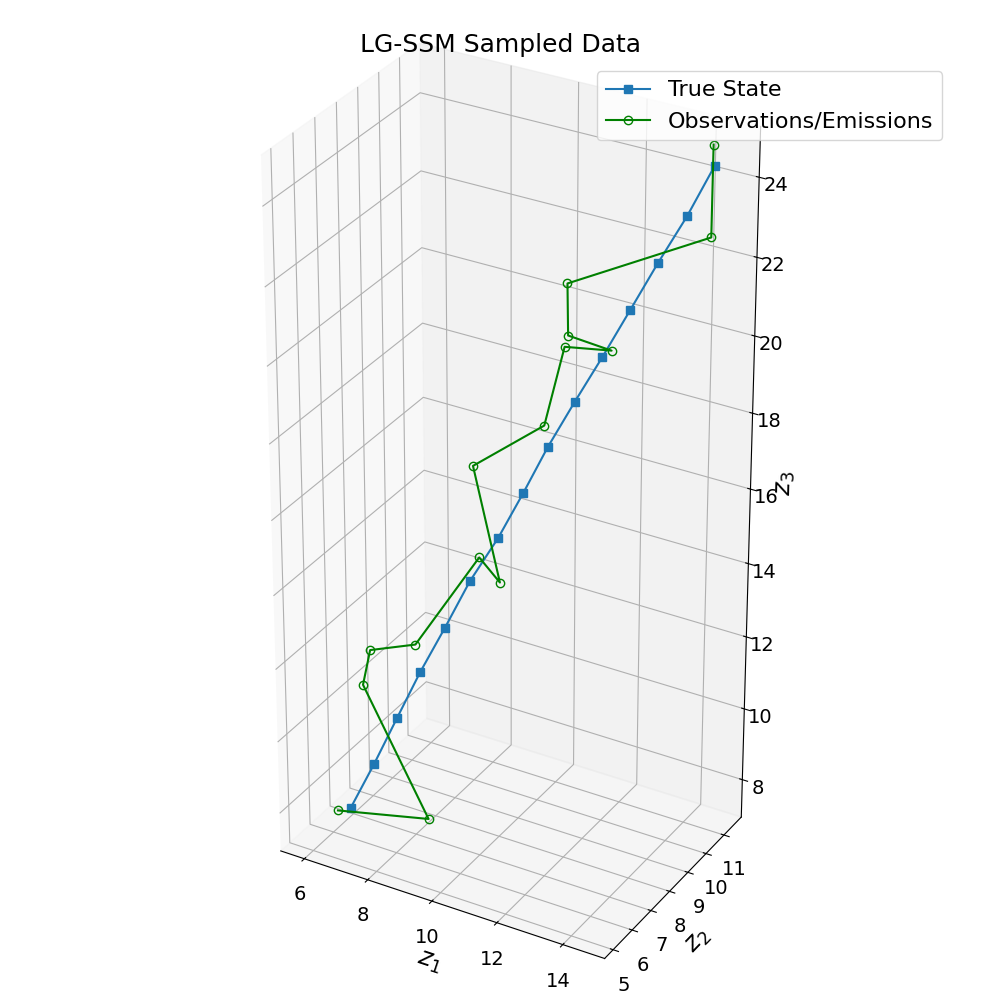

In [3]:
num_timesteps = 15
z_t, x_t = lgssm.sample(params, key, num_timesteps)

fig = plt.figure(figsize=(10, 10))
ax_3d = fig.add_subplot(111, projection='3d')

# Plot data
ax_3d.plot(z_t[:, 0], z_t[:, 1], z_t[:, 2], marker='s', color='C0', label="True State")
ax_3d.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], marker='o', markerfacecolor='none', color='green', label="Observations/Emissions")
ax_3d.set_xlabel(r"$z_1$")
ax_3d.set_ylabel(r"$z_2$")
ax_3d.set_zlabel(r"$z_3$")
ax_3d.legend(loc='upper left')
# Set equal axes for 3D plots
ax_3d.set_box_aspect((jnp.ptp(x_t[:, 0]), jnp.ptp(x_t[:, 1]), jnp.ptp(x_t[:, 2])))

plt.title("LG-SSM Sampled Data")
plt.legend()
plt.tight_layout()

The following is a utility function inspired by the 2-D object tracking example provided [here](https://probml.github.io/dynamax/notebooks/linear_gaussian_ssm/kf_tracking.html), borrowing another useful 3-D plotting function from the [filterpy](https://github.com/rlabbe/filterpy) library (you can `pip install filterpy`). FilterPy is another excellent Python library for Kalman filtering and state estimation. We opt for Dynamax here to reap the benefits of performance in parallel processing contexts, e.g., when performing [multiple object tracking](#Tracking-Multiple-Objects).

In [4]:
from filterpy.stats import plot_3d_covariance

# https://stackoverflow.com/questions/30196503/2d-plots-are-not-sitting-flush-against-3d-axis-walls-in-python-mplot3d/41779162#41779162
# To do with setting the 3-D axes to span the plot correctly
def get_fixed_mins_maxs(mins, maxs):
    deltas = (maxs - mins) / 12.
    mins = mins + deltas / 4.
    maxs = maxs - deltas / 4.

    return [mins, maxs]
    
def plot_lgssm_posterior(post_means, post_covs, ax, ellipsoid_kwargs={}, legend_kwargs={}, **kwargs):
    """Plot posterior means and covariances for the first three dimensions of
     the latent state of an LGSSM.

    Args:
        post_means: array(T, D).
        post_covs: array(T, D, D).
        ax: matplotlib axis, assumed to be 3-D.
        ellipsoid_kwargs: keyword arguments passed to plot_3d_covariance.
        **kwargs: passed to ax.plot().
    """

    # Select the first three dimensions of the latent space.
    post_means = post_means[:, :3]
    post_covs = post_covs[:, :3, :3]

    # Plot the mean trajectory
    ax.plot(post_means[:, 0], post_means[:, 1], post_means[:, 2], **kwargs)
    
    # Plot covariance at each time point as a 3-D ellipsoid
    num_steps = post_means.shape[0]
    for t in range(num_steps):
        plot_3d_covariance(post_means[t], post_covs[t], ax=ax, **ellipsoid_kwargs)

    if 'label' in kwargs:
        ax.legend(**legend_kwargs)

    return ax

### Online Bayesian Filtering

The following code applies a KF to perform online filtering in our LG-SSM:

In [5]:
lgssm_posterior = lgssm.filter(params, x_t) # Kalman filter
print(lgssm_posterior.filtered_means.shape)
print(lgssm_posterior.filtered_covariances.shape)
print(lgssm_posterior.marginal_loglik)

(15, 6)
(15, 6, 6)
-70.19963


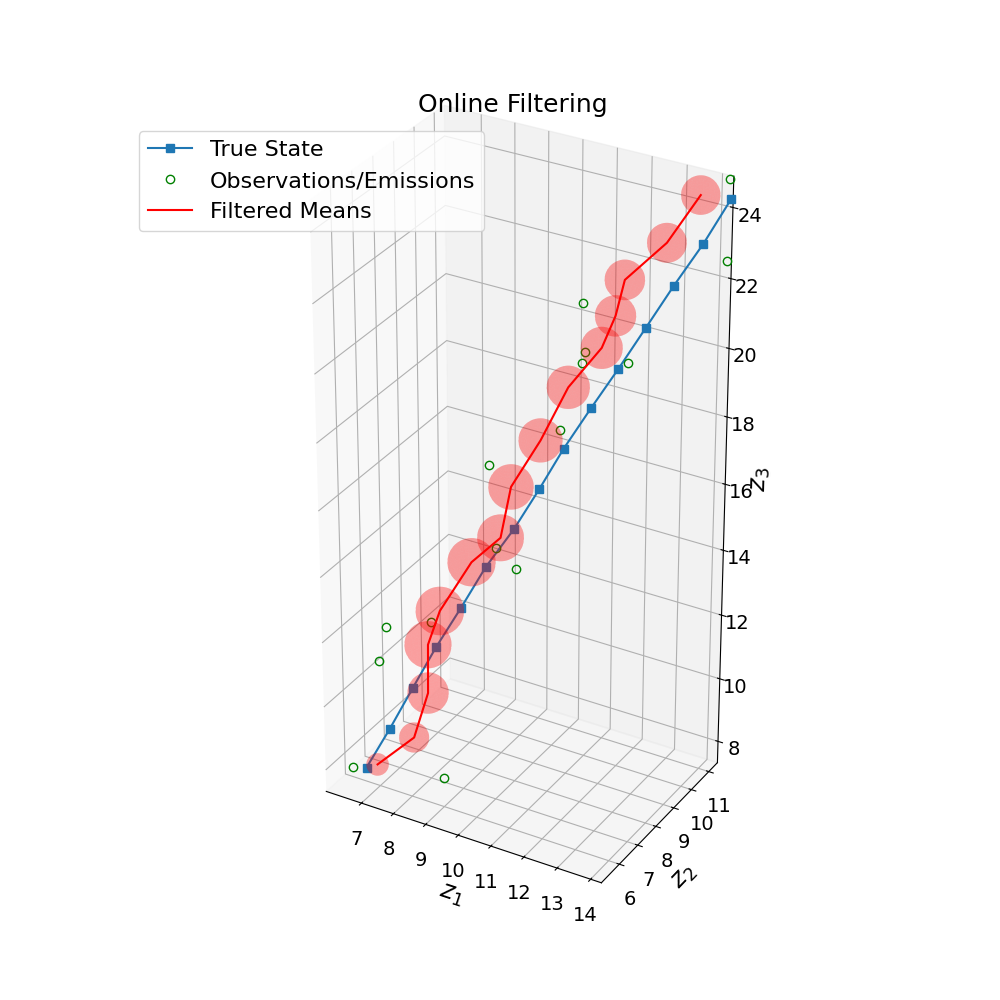

In [6]:
filter_fig = plt.figure(figsize=(10, 10))
ax_filter = filter_fig.add_subplot(111, projection='3d')

ax_filter.plot(z_t[:, 0], z_t[:, 1], z_t[:, 2], marker='s', color='C0', label="True State")
ax_filter.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], ls='', marker='o', markerfacecolor='none', color='green', label="Observations/Emissions")

ax_filter = plot_lgssm_posterior(
    lgssm_posterior.filtered_means,
    lgssm_posterior.filtered_covariances,
    ax_filter,
    color='red',
    label="Filtered Means",
    ellipsoid_kwargs={'alpha': 0.2, 'color': 'red', 'shade': False},
    legend_kwargs={'loc':'upper left'}
)

# Set each axis limits with the minmax value from our function
ax_filter.set_xlim(get_fixed_mins_maxs(jnp.min(x_t[:,0]), jnp.max(x_t[:,0])))
ax_filter.set_ylim(get_fixed_mins_maxs(jnp.min(x_t[:,1]), jnp.max(x_t[:,1]))) 
ax_filter.set_zlim(get_fixed_mins_maxs(jnp.min(x_t[:,2]), jnp.max(x_t[:,2]))) 
# Set equal axes for 3D plots
ax_filter.set_box_aspect((jnp.ptp(x_t[:, 0]), jnp.ptp(x_t[:, 1]), jnp.ptp(x_t[:, 2])))

ax_filter.set_xlabel(r"$z_1$")
ax_filter.set_ylabel(r"$z_2$")
ax_filter.set_zlabel(r"$z_3$")

plt.title("Online Filtering")
plt.legend()

## Tracking Multiple Objects

There is no reason we cannot extend the KF tracking example to a known number $N$ of objects. Let's provide some brief code to illustrate this:

In [7]:
# Generate N sample trajectories
num_timesteps = 15
N = 4
# Split the pseudo-random generator into N keys given our original seed
keys = jr.split(key, N)
# Vectorizing map (vmap) to sample from each LG-SSM using a new key each time
# Use the same parameters for our LG-SSM as in the single object tracking example
z_Nt, x_Nt = vmap(lambda key: lgssm.sample(params, key, num_timesteps))(keys)

In [8]:
# vmap the posterior inference
lgssm_posteriors = vmap(lambda x_t: lgssm.filter(params, x_t))(x_Nt)

And again, the following plotting code is heavily inspired by [this multi-object tracking example](https://github.com/probml/dynamax/blob/main/docs/notebooks/linear_gaussian_ssm/kf_tracking.ipynb):

In [9]:
def plot_kf_parallel(z_Nt, x_Nt, lgssm_posteriors):
    N = len(z_Nt)
    dict_figures = {}

    # Plot Data
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for n in range(N):
        ax.plot(z_Nt[n, :, 0], z_Nt[n, :, 1], z_Nt[n, :, 2], ls="--", color=f"C{n}")
        ax.plot(x_Nt[n, :, 0], x_Nt[n, :, 1], x_Nt[n, :, 2], ".", color=f"C{n}", label=f"Trajectory {n+1}")
    
    # Set each axis limits with the minmax value from our function
    ax.set_xlim(get_fixed_mins_maxs(jnp.min(x_Nt[:, :, 0]), jnp.max(x_Nt[:, :, 0])))
    ax.set_ylim(get_fixed_mins_maxs(jnp.min(x_Nt[:, :, 1]), jnp.max(x_Nt[:, :, 1]))) 
    ax.set_zlim(get_fixed_mins_maxs(jnp.min(x_Nt[:, :, 2]), jnp.max(x_Nt[:, :, 2]))) 
    # Set equal axes for 3D plots
    ax.set_box_aspect((jnp.ptp(x_Nt[:, :, 0]), jnp.ptp(x_Nt[:, :, 1]), jnp.ptp(x_Nt[:, :, 2])))
    
    ax.set_title("True State Data")
    ax.legend()
    
    dict_figures["true_state"] = fig

    # Plot Filtering
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for n in range(N):
        ax.plot(x_Nt[n, :, 0], x_Nt[n, :, 1], x_Nt[n, :, 2], ".")
        filt_means = lgssm_posteriors.filtered_means[n, ...]
        filt_covs = lgssm_posteriors.filtered_covariances[n, ...]
        plot_lgssm_posterior(
            filt_means,
            filt_covs,
            ax,
            color=f'C{n}',
            ellipsoid_kwargs={'alpha': 0.2, 'color': f'C{n}', 'shade': False},
            label=f"Trajectory {n+1}",
        )

    # Set each axis limits with the minmax value from our function
    ax.set_xlim(get_fixed_mins_maxs(jnp.min(x_Nt[:, :, 0]), jnp.max(x_Nt[:, :, 0])))
    ax.set_ylim(get_fixed_mins_maxs(jnp.min(x_Nt[:, :, 1]), jnp.max(x_Nt[:, :, 1]))) 
    ax.set_zlim(get_fixed_mins_maxs(jnp.min(x_Nt[:, :, 2]), jnp.max(x_Nt[:, :, 2])))
    # Set equal axes for 3D plots
    ax.set_box_aspect((jnp.ptp(x_Nt[:, :, 0]), jnp.ptp(x_Nt[:, :, 1]), jnp.ptp(x_Nt[:, :, 2])))
    
    ax.set_title("Filtered Posteriors")
    ax.legend()
    
    dict_figures["filtered_state"] = fig

    return dict_figures

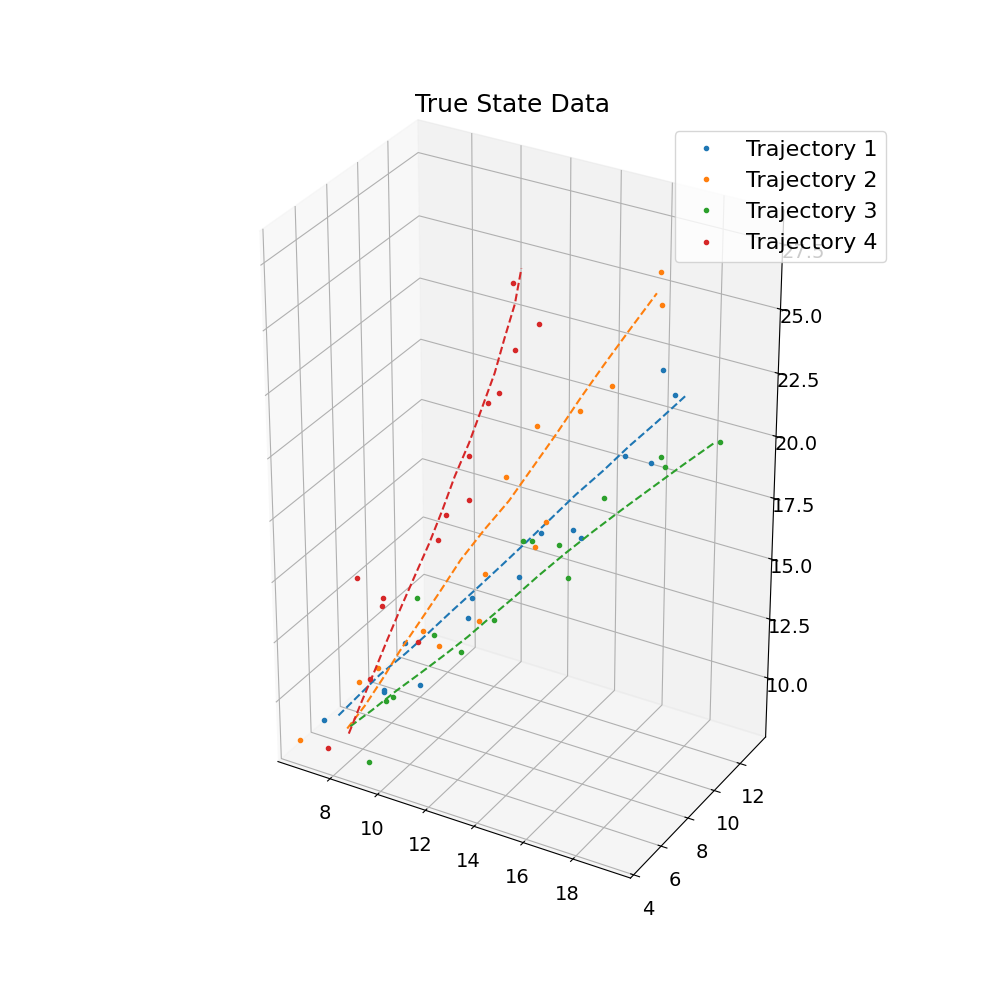

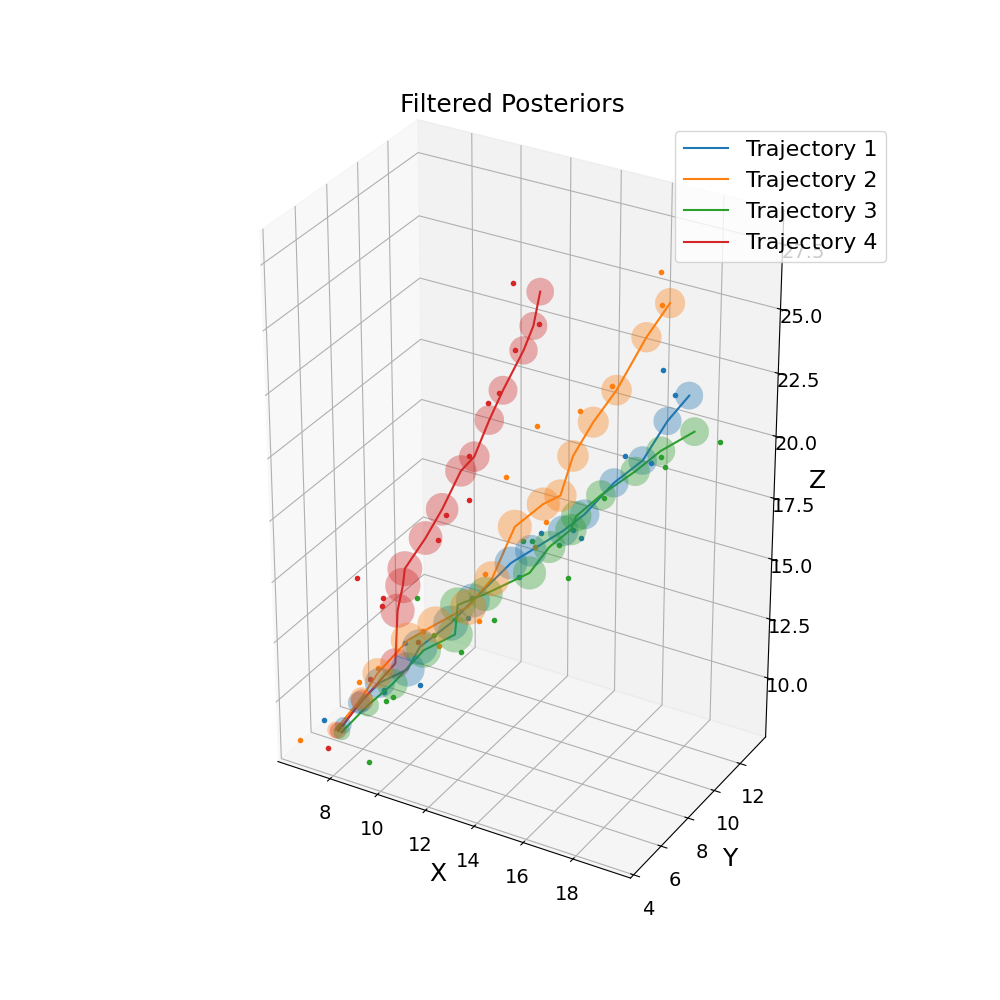

In [10]:
dict_figures = plot_kf_parallel(z_Nt, x_Nt, lgssm_posteriors)

## Variants of the KF

Recall that the KF makes a few key assumptions:
1. All our posterior distributions in the SSM at every timestep are Gaussian.
2. The system dynamics and observation model are <b>linear</b>. Additionally, their functional specification is known, i.e., we know matrices $\mathbf{F}$ and $\mathbf{H}$.
3. The noise processes are independent Gaussian distributions, defined by known covariance matrices, $\mathbf{Q}$ and $\mathbf{R}$. We also usually assume these additive Gaussian noise processes are zero mean, but this is not a hard requirement of the KF.

In this notebook, we will not go into detail about the variants of KFs. Nevertheless, there are two well-known variants that allow us to bend the second assumption of linearity, such that the system dynamics and/or observation model can be [non-linear](https://en.wikipedia.org/wiki/Kalman_filter#Nonlinear_filters):
- <b>Extended Kalman Filter (EKF):</b> The EKF algorithm is based on the idea of linearizing the non-linear dynamics and observation models about the previous state estimate using a first-order Taylor series expansion. After approximating inference in our non-linear models via this local linearization technique, the standard KF equations can then be applied. Note that additive Gaussian noise is still assumed (Assumption \#3) and that higher order EKF approximations are possible, but are computationally more costly despite yielding better accuracy.
- <b>Unscented Kalman Filter (UKF):</b> Instead of using local linearization to approximate the non-linear system functions, the UKF algorithm computes a set of points, known as <i>sigma points</i>, which will approximate the underlying model distributions as Gaussian. A non-linear transformation, known as the <i>unscented transform</i>, is applied to create these sigma points. These sigma points are then propagated through the nonlinear system model $\mathbf{f}$ and measurement model $\mathbf{h}$ to produce new state mean and state covariance estimates from the transformed points. The UKF is generally more accurate and stable than the EKF algorithm, however it can be slower and also requires three hyperparameters to be configured.

There are also other inference methods for SSMs that are flexible and evade all three assumptions. For example, <b>particle filters</b> can be applied to SSMs defined by non-linear functions and subject to noise distributions of any form. They do so by adopting a more flexible representation of the posterior using a set of weighted samples, referred to as "particles".

Please refer to Chapter 8.7 of Murphy's book on these alternative inference methods for SSMs, as well as later chapters for a more in-depth discussion (e.g., Chapter 13.2 on "Particle Filtering", or Chapter 29 on "SSMs"). 

## References

Code adapted from <i>"kf_tracking.ipynb"</i> at:

@book{pml2Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: Advanced Topics",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2023,<br>
&emsp; url = "http://probml.github.io/book2"<br>
}